# Fine-Grained Image Classification

In [1]:
!nvidia-smi

Sun Dec 10 20:37:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0               10W /  N/A|    261MiB /  4096MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Import Packages


In [2]:
# !pip install tqdm
# !pip install pytorch 
# !pip install torchvision
# !pip install torchensemble

In [3]:
import os
import numpy as np
from PIL import Image
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder

In [4]:
myseed = 666
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
# torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(myseed)
    torch.cuda.manual_seed_all(myseed)

### Transforms

In [5]:
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# train_tfm = transforms.Compose([
#     transforms.RandomResizedCrop(448),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90, interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225]),
# ])

# test_tfm = transforms.Compose([
#     transforms.Resize(int(448/0.875)),
#     transforms.CenterCrop(448),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406),
#                             std=(0.229, 0.224, 0.225)),
# ])


### Datasets

In [6]:
# class TrainingDataset(Dataset):
#     def __init__(self, img_dir, transform=None):
#         """
#         data
#         ├── train
#         |   ├── class1
#         |   |   ├── xxxxx.jpg
#         |   |   ├── ...
#         |   |   └── yyyyy.jpg
#         |   |
#         |   ├── ...
#         """
#         self.img_dir = img_dir
#         self.transform = transform
#         self.images = []
#         self.labels = []
#         self.names = []

#         for i, class_dir in enumerate(glob.glob(f"{self.img_dir}/*")):
#             images = glob.glob(f"{class_dir}/*")
#             self.images += images
#             self.labels += [i] * len(images)
#             self.names += [os.path.basename(image)[:-4] for image in images]

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.transform(Image.open(self.images[idx]))
#         label = self.labels[idx]
#         return image, label
    

class TestingDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        data
        ├── test
        |   ├── xxxxx.jpg
        |   ├── ...
        |   └── yyyyy.jpg
        """
        self.img_dir = img_dir
        self.transform = transform
        self.images = []
        self.names = []

        self.images = sorted(glob.glob(f"{self.img_dir}/*"))
        self.names = [os.path.basename(image)[:-4] for image in self.images]

    def __len__(self):
        return len(self.images)
    
    def __getnames__(self):
        return self.names
    
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        return image

Total training data: 9788


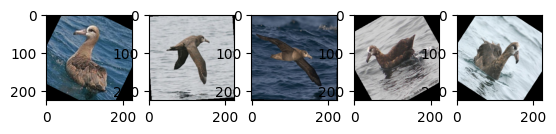

Total testing data: 2000


In [7]:
train_set = ImageFolder("../data/train", train_tfm)
test_set = TestingDataset("../data/test", test_tfm)

print(f"Total training data: {train_set.__len__()}")

# img, label = train_set.__getitem__(0)
# plt.imshow(img.permute(1, 2, 0))
# plt.show()

for i in range(5):
    img, _ = train_set.__getitem__(i)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.permute(1, 2, 0))
plt.show()


print(f"Total testing data: {test_set.__len__()}")
# img = test_set.__getitem__(0)
# print(test_set.__getnames__()[0])
# plt.imshow(img.permute(1, 2, 0))
# plt.show()

### Models

In [8]:
class Resnet(nn.Module):
    def __init__(self, num_classes=200):
        super(Resnet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

### Configurations

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
epochs = 100

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

model = Resnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Start Training

In [10]:
best_acc = 0.0

for epoch in range(epochs):
    # if (epoch+1) % 30 == 0:
    #     for param_group in optimizer.param_groups:
    #         param_group['lr'] *= 0.1

    model.train()
    train_loss = []
    train_accs = []

    with tqdm(total=len(train_loader), unit="batch") as tqdm_bar:
        tqdm_bar.set_description(f"Epoch {epoch+1:03d}/{epochs}")
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            logits = model(images)

            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            acc = (logits.argmax(dim=1) == labels).float().mean()
            train_accs.append(acc)
            tqdm_bar.set_postfix(loss=f"{sum(train_loss)/len(train_loss):.5f}", acc=f"{sum(train_accs)/len(train_accs):.5f}")
            tqdm_bar.update(1)

        scheduler.step()

        tqdm_bar.set_postfix(loss=f"{sum(train_loss)/len(train_loss):.5f}", acc=f"{sum(train_accs)/len(train_accs):.5f}")
        tqdm_bar.close()

        if sum(train_accs)/len(train_accs) > best_acc:
            best_acc = sum(train_accs)/len(train_accs)
            torch.save(model.state_dict(), f"resnet50_.pth")


Epoch 100/100: 100%|██████████| 306/306 [02:48<00:00,  1.81batch/s, acc=0.99847, loss=0.04858]


### Inference

In [11]:
import pandas as pd


model = Resnet().to(device)
model.load_state_dict(torch.load("resnet50_.pth"))
model.eval()

predictions = []
with torch.no_grad():
    for i, images in enumerate(tqdm(test_loader)):
        images = images.to(device)
        logits = model(images)
        predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


100%|██████████| 63/63 [00:30<00:00,  2.09it/s]


In [12]:
class_dic = {}
for i, class_dir in enumerate(train_set.classes):
    class_dic[i] = os.path.basename(class_dir)

predictions = [class_dic[pred] for pred in predictions]

submission = pd.DataFrame({"id": test_set.__getnames__(), "label": predictions})
submission.to_csv("../submission_new.csv", index=False)